In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install langgraph langgraph-sdk langgraph-checkpoint-sqlite langsmith>=0.2.0 langchain-community langchain-core networkx langchain_experimental
!pip install langchain-openai notebook python-dotenv lxml scikit-learn pandas pyarrow mistralai langchain_mistralai beautifulsoup4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.6/271.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.1/463.1 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.57.4
    Uninstalling openai-1.57.4:
      Successfully uninstalled openai-1.57.4


In [3]:
from openai import OpenAI
from typing import List
import os
import getpass
import tempfile
import torch
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain 
# from langchain_huggingface.llms import HuggingFacePipeline
import transformers
import yfinance as yf
import pandas as pd
import numpy as np
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.agents import create_pandas_dataframe_agent
from langchain_experimental.agents.agent_toolkits import create_csv_agent
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_mistralai import ChatMistralAI
from mistralai import Mistral
import nest_asyncio
from langchain_mistralai import MistralAIEmbeddings
import pprint
# from langchain_neo4j import GraphCypherQAChain, Neo4jGraph
from langchain_community.graphs.index_creator import GraphIndexCreator
from langchain.chains import GraphQAChain
from langchain_openai import OpenAI
from langchain.graphs.networkx_graph import KnowledgeTriple, parse_triples, NetworkxEntityGraph
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import SVG
from langchain_core.tools import StructuredTool
import json

In [4]:
# if not os.environ.get('MISTRAL_API_KEY'):
#      os.environ['MISTRAL_API_KEY'] = getpass.getpass('Mistral API Key')

# os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
if not os.environ.get('LANGSMITH_KEY'):
    os.environ['LANGSMITH_KEY'] = getpass.getpass('Enter LANGSMITH Key')

# if not os.environ.get('TAVILY_KEY'):
#     os.environ['TAVILY_KEY'] = getpass.getpass('Enter TAVILY Key')

if not os.environ.get('OPENAI_API_KEY'):
    os.environ['OPENAI_API_KEY'] = getpass.getpass('Enter OPENAI Key')

Enter LANGSMITH Key ········
Enter OPENAI Key ········


In [5]:
# Building a graph

network_graph = nx.MultiGraph()
network_graph.add_node("Hyderabad")
network_graph.add_node("Bangalore")
network_graph.add_node("Chennai")
network_graph.add_node("Amaravati")
network_graph.add_node("Delhi")

network_graph.add_edges_from([("Hyderabad", "Bangalore", {'distance' : 100, 'max_bandwidth' : 60, 'available_bandwidth' : 60, 'jitter' : 2, 'latency' : 6})])
network_graph.add_edges_from([("Hyderabad", "Bangalore", {'max_bandwidth' : 70, 'available_bandwidth' : 70, 'latency' : 7})])


network_graph.add_edges_from([("Hyderabad", "Delhi", {'distance' : 120, 'max_bandwidth' : 120, 'available_bandwidth' : 120, 'jitter' : 3, 'latency' : 12})])


network_graph.add_edges_from([("Hyderabad", "Amaravati", {'distance' : 50, 'max_bandwidth' : 50, 'available_bandwidth' : 50, 'jitter' : 1, 'latency' : 5})])
network_graph.add_edges_from([("Hyderabad", "Amaravati", {'max_bandwidth' : 70, 'available_bandwidth' : 70, 'latency' : 7})])
network_graph.add_edges_from([("Hyderabad", "Amaravati", {'max_bandwidth' : 60, 'available_bandwidth' : 60, 'latency' : 6})])


network_graph.add_edges_from([("Bangalore", "Chennai", {'distance' : 120, 'max_bandwidth' : 120, 'available_bandwidth' : 120, 'jitter' : 3, 'latency' : 12})])


network_graph.add_edges_from([("Bangalore", "Delhi", {'distance' : 10, 'max_bandwidth' : 50, 'available_bandwidth' : 50, 'jitter' : 1, 'latency' : 5})])
network_graph.add_edges_from([("Bangalore", "Delhi", {'max_bandwidth' : 70, 'available_bandwidth' : 70, 'latency' : 7})])
network_graph.add_edges_from([("Bangalore", "Delhi", {'max_bandwidth' : 60, 'available_bandwidth' : 60, 'latency' : 6})])


network_graph.add_edges_from([("Bangalore", "Amaravati", {'distance' : 30, 'max_bandwidth' : 50, 'available_bandwidth' : 50, 'jitter' : 1, 'latency' : 5})])
network_graph.add_edges_from([("Bangalore", "Amaravati", {'max_bandwidth' : 70, 'available_bandwidth' : 70, 'latency' : 7})])
network_graph.add_edges_from([("Bangalore", "Amaravati", {'max_bandwidth' : 60, 'available_bandwidth' : 60, 'latency' : 6})])


network_graph.add_edges_from([("Amaravati", "Delhi", {'distance' : 60, 'max_bandwidth' : 60, 'available_bandwidth' : 60, 'jitter' : 2, 'latency' : 6})])
network_graph.add_edges_from([("Amaravati", "Delhi", {'max_bandwidth' : 70, 'available_bandwidth' : 70, 'latency' : 7})])


network_graph.add_edges_from([("Chennai", "Delhi", {'distance' : 80, 'max_bandwidth' : 70, 'available_bandwidth' : 70, 'jitter' : 2, 'latency' : 7})])
network_graph.add_edges_from([("Chennai", "Delhi", {'max_bandwidth' : 80, 'available_bandwidth' : 80, 'latency' : 8})])

[1]

In [6]:
print(network_graph.nodes)
print(network_graph.edges)
print(network_graph.adj)

['Hyderabad', 'Bangalore', 'Chennai', 'Amaravati', 'Delhi']
[('Hyderabad', 'Bangalore', 0), ('Hyderabad', 'Bangalore', 1), ('Hyderabad', 'Delhi', 0), ('Hyderabad', 'Amaravati', 0), ('Hyderabad', 'Amaravati', 1), ('Hyderabad', 'Amaravati', 2), ('Bangalore', 'Chennai', 0), ('Bangalore', 'Delhi', 0), ('Bangalore', 'Delhi', 1), ('Bangalore', 'Delhi', 2), ('Bangalore', 'Amaravati', 0), ('Bangalore', 'Amaravati', 1), ('Bangalore', 'Amaravati', 2), ('Chennai', 'Delhi', 0), ('Chennai', 'Delhi', 1), ('Amaravati', 'Delhi', 0), ('Amaravati', 'Delhi', 1)]
{'Hyderabad': {'Bangalore': {0: {'distance': 100, 'max_bandwidth': 60, 'available_bandwidth': 60, 'jitter': 2, 'latency': 6}, 1: {'max_bandwidth': 70, 'available_bandwidth': 70, 'latency': 7}}, 'Delhi': {0: {'distance': 120, 'max_bandwidth': 120, 'available_bandwidth': 120, 'jitter': 3, 'latency': 12}}, 'Amaravati': {0: {'distance': 50, 'max_bandwidth': 50, 'available_bandwidth': 50, 'jitter': 1, 'latency': 5}, 1: {'max_bandwidth': 70, 'available

In [6]:
# print(len(G.adj['Hyderabad']['Bangalore']))
# print(G.adj['Hyderabad']['Bangalore'])

source_name = 'Hyderabad'
destination_name = 'Bangalore'
for i in range(len(network_graph.adj[source_name][destination_name])):
    print(f'\n{source_name} to {destination_name} line {i}')
    if(i==0):
        print(f"distance : {network_graph.adj[source_name][destination_name][i]['distance']}")
        print(f"max_bandwidth: {network_graph.adj[source_name][destination_name][i]['max_bandwidth']}")
        print(f"available_bandwidth: {network_graph.adj[source_name][destination_name][i]['available_bandwidth']}")
        print(f"jitter: {network_graph.adj[source_name][destination_name][i]['jitter']}")
        print(f"latency: {network_graph.adj[source_name][destination_name][i]['latency']}")
    else:
        print(f"max_bandwidth: {network_graph.adj[source_name][destination_name][i]['max_bandwidth']}")
        print(f"available_bandwidth: {network_graph.adj[source_name][destination_name][i]['available_bandwidth']}")
        print(f"jitter: {network_graph.adj[source_name][destination_name][0]['jitter']}")
        print(f"latency: {network_graph.adj[source_name][destination_name][i]['latency']}")
        
    
    


Hyderabad to Bangalore line 0
distance : 100
max_bandwidth: 60
available_bandwidth: 60
jitter: 2
latency: 6

Hyderabad to Bangalore line 1
max_bandwidth: 70
available_bandwidth: 70
jitter: 2
latency: 7


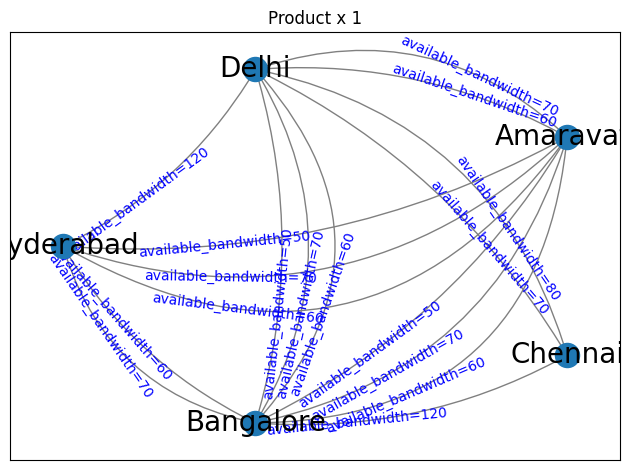

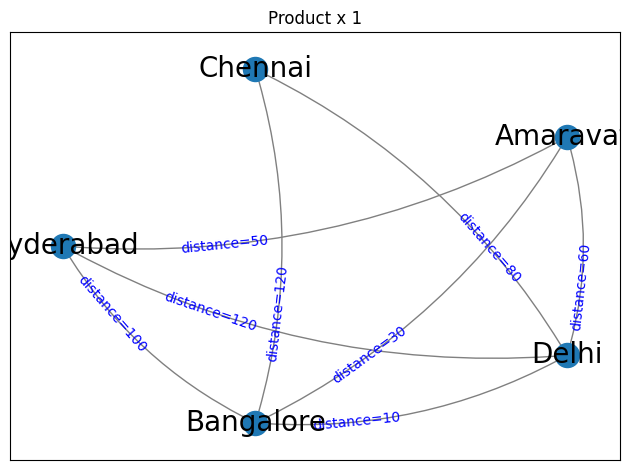

In [7]:
import itertools as it
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


def draw_labeled_multigraph(network_graph, attr_name, ax=None):
    """
    Length of connectionstyle must be at least that of a maximum number of edges
    between pair of nodes. This number is maximum one-sided connections
    for directed graph and maximum total connections for undirected graph.
    """
    # Works with arc3 and angle3 connectionstyles
    connectionstyle = [f"arc3,rad={r}" for r in it.accumulate([0.15] * 4)]
    # connectionstyle = [f"angle3,angleA={r}" for r in it.accumulate([30] * 4)]

    pos = nx.shell_layout(network_graph)
    nx.draw_networkx_nodes(network_graph, pos, ax=ax)
    nx.draw_networkx_labels(network_graph, pos, font_size=20, ax=ax)
    nx.draw_networkx_edges(
        network_graph, pos, edge_color="grey", connectionstyle=connectionstyle, ax=ax
    )

    labels = {
        tuple(edge): f"{attr_name}={attrs[attr_name]}"
        for *edge, attrs in network_graph.edges(keys=True, data=True)
    }
    nx.draw_networkx_edge_labels(
        network_graph,
        pos,
        labels,
        connectionstyle=connectionstyle,
        label_pos=0.3,
        font_color="blue",
        bbox={"alpha": 0},
        ax=ax,
    )

nodes = "ABC"
prod = list(it.product(network_graph.nodes, repeat=2))
pair_dict = {f"Product x {i}": prod * i for i in range(1, 2)}
fig, axes = plt.subplots(1, 1)

for (name, pairs), ax in zip(pair_dict.items(), np.ravel(axes)):
    draw_labeled_multigraph(network_graph, "available_bandwidth", ax)
    ax.set_title(name)
fig.tight_layout()
plt.show()

distance_graph = nx.MultiGraph()
for i in network_graph.edges:
    if(i[2] == 0):
        a_node = i[0]
        z_node = i[1]
        # print(a_node, z_node)
        # print(G[a_node][z_node][i[2]]['distance'])
        distance_graph.add_nodes_from([a_node,z_node])
        distance_graph.add_edges_from([(a_node,z_node,{'distance':network_graph[a_node][z_node][i[2]]['distance']})])
        
fig, axes = plt.subplots(1, 1)
for (name, pairs), ax in zip(pair_dict.items(), np.ravel(axes)):
    draw_labeled_multigraph(distance_graph, "distance", ax)
    ax.set_title(name)
fig.tight_layout()
plt.show()

In [8]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

llm2 = ChatOpenAI(model = 'gpt-4o-mini')

In [9]:
def get_shortest_path(network_graph, source_name:str, destination_name:str):
    """
    Calculates the shortest path between two nodes in a graph.

    This function utilizes the `networkx.shortest_path` function to find the
    shortest path between a source node and a destination node within a given graph.

    :param network_graph: The graph to search within. This should be a NetworkX graph object.
    :type network_graph: networkx.Graph

    :param source_name: The name of the source node from which the shortest path begins.
    :type source_name: str

    :param destination_name: The name of the destination node where the shortest path ends.
    :type destination_name: str

    :raises NetworkXNoPath: If there is no path between the source and destination nodes.
    :raises NodeNotFound: If either the source or destination node is not found in the graph.

    :returns: A list of node names representing the nodes in the shortest path,
              starting from the source node and ending at the destination node.
    :rtype: List[str]
    """
    distance_graph = nx.MultiGraph()
    for i in network_graph.edges:
        if(i[2] == 0):
            a_node = i[0]
            z_node = i[1]
            distance_graph.add_nodes_from([a_node,z_node])
            distance_graph.add_edges_from([(a_node,z_node,{'distance':network_graph[a_node][z_node][i[2]]['distance']})])
    
    return nx.shortest_path(distance_graph, source_name, destination_name, weight = 'distance')


async def aget_shortest_path(network_graph, source_name, destination_name):
    """
    Calculates the shortest path between two nodes in a graph.

    This function utilizes the `networkx.shortest_path` function to find the
    shortest path between a source node and a destination node within a given graph.

    :param network_graph: The graph to search within. This should be a NetworkX graph object.
    :type network_graph: networkx.Graph

    :param source_name: The name of the source node from which the shortest path begins.
    :type source_name: str

    :param destination_name: The name of the destination node where the shortest path ends.
    :type destination_name: str

    :raises NetworkXNoPath: If there is no path between the source and destination nodes.
    :raises NodeNotFound: If either the source or destination node is not found in the graph.

    :returns: A list of node names representing the nodes in the shortest path,
              starting from the source node and ending at the destination node.
    :rtype: List[str]
    """
    distance_graph = nx.MultiGraph()
    for i in network_graph.edges:
        if(i[2] == 0):
            a_node = i[0]
            z_node = i[1]
            distance_graph.add_nodes_from([a_node,z_node])
            distance_graph.add_edges_from([(a_node,z_node,{'distance':network_graph[a_node][z_node][i[2]]['distance']})])
    return nx.shortest_path(distance_graph, source_name, destination_name, weight = 'distance')
    


get_shortest_path = StructuredTool.from_function(func=get_shortest_path, coroutine=aget_shortest_path)

In [49]:
# def get_path_distance(network_graph, path_nodes_list:List):
#     """
#     Calculates the total distance of a path in a graph, given a list of nodes that define the path.

#     :param network_graph: The graph to search within.
#     :type network_graph: networkx.Graph

#     :param path_nodes_list: List of nodes for which the path distance needs to be calculated.
#     :type List (A Python list)

#     :raises NetworkXNoPath: If there is no path between the source and destination nodes.
#     :raises NodeNotFound: If either the source or destination node is not found in the graph.

#     :returns: The total calculated distance
#     :rtype: int (A whole number).
#     """
#     distance_graph = nx.MultiGraph()
#     for i in network_graph.edges:
#         if(i[2] == 0):
#             a_node = i[0]
#             z_node = i[1]
#             distance_graph.add_nodes_from([a_node,z_node])
#             distance_graph.add_edges_from([(a_node,z_node,{'distance':network_graph[a_node][z_node][i[2]]['distance']})])
            
#     distance = 0
#     for i in range(len(path_nodes_list)-1):
#         distance += distance_graph[path_nodes_list[i]][path_nodes_list[i+1]][0]['distance']
#     return distance


# async def aget_path_distance(network_graph, path_nodes_list:List):
#     """
#     Calculates the total distance of a path in a graph, given a list of nodes that define the path.

#     :param network_graph: The graph to search within.
#     :type network_graph: networkx.Graph

#     :param path_nodes_list: List of nodes for which the path distance needs to be calculated.
#     :type List (A Python list)

#     :raises NetworkXNoPath: If there is no path between the source and destination nodes.
#     :raises NodeNotFound: If either the source or destination node is not found in the graph.

#     :returns: The total calculated distance
#     :rtype: int (A whole number).
#     """

#     distance_graph = nx.MultiGraph()
#     for i in network_graph.edges:
#         if(i[2] == 0):
#             a_node = i[0]
#             z_node = i[1]
#             distance_graph.add_nodes_from([a_node,z_node])
#             distance_graph.add_edges_from([(a_node,z_node,{'distance':network_graph[a_node][z_node][i[2]]['distance']})])
            
#     distance = 0
#     for i in range(len(path_nodes_list)-1):
#         distance += distance_graph[path_nodes_list[i]][path_nodes_list[i+1]][0]['distance']
#     return distance





def get_path_distance(path_nodes_list:List, network_graph_adjacency_matrix, llm):
    """
    Calculates the total distance of a path in a graph, given a list of nodes that define the path.

    :param path_nodes_list: List of nodes for which the path distance needs to be calculated.
    :rtype: List (A Python list)

    :param network_graph_adjacency_matrix: Graph's adjacency matrix to search within.
    :rtype: Dict

    :param llm: An intelligent Large Language model for question answering
    :rtype: langchain_openai.chat_models.base.ChatOpenAI

    :raises NetworkXNoPath: If there is no path between the source and destination nodes.
    :raises NodeNotFound: If either the source or destination node is not found in the graph.

    :returns: The total calculated distance
    :rtype: int (A whole number).
    """
    prompt = f"""
            You are given a {network_graph_adjacency_matrix} representing distances between cities.  
            The adjacency matrix is a dictionary where:
            *   Keys are city names (strings).
            *   Values are dictionaries representing connections to other cities.
                *   These inner dictionaries have city names as keys.
                *   Their values are *another* dictionary representing *multiple possible links* between the two cities.
                    *   These innermost dictionaries have integer keys (e.g., 0, 1, 2) representing different links.
                    *   Only link 0 contain a 'distance' key.  The 'distance' key, holds the distance value for that specific link.
            
            **Task:**
            
            Calculate the total distance of a given {path_nodes_list}. The path is a list of city names in the order they are visited.
            
            **Crucial Rule for Distance Selection:**
            
            When determining the distance between two adjacent cities in the path, you MUST follow this rule:
            
            1.  **Use only Link 0:**  Always check the link with key `0` between the two cities.  Use the value of that 'distance' key.
            2. **Invalid Path:** If, at any point, there is no direct connection between two consecutive cities in the path (i.e., the second city is not a neighbor of the first in the adjacency matrix), the path is invalid.  
                
            **Output:**
            
            Return a single integer representing the total distance of the valid path.  If the path is invalid (due to missing connections or missing distance information according to the rules above), return the string "Invalid path".
            Ensure you always give correct result.
            """
    
    return llm.invoke(prompt)


async def aget_path_distance(path_nodes_list:List, network_graph_adjacency_matrix, llm):
    """
    Calculates the total distance of a path in a graph, given a list of nodes that define the path.

    :param path_nodes_list: List of nodes for which the path distance needs to be calculated.
    :rtype: List (A Python list)

    :param network_graph_adjacency_matrix: Graph's adjacency matrix to search within.
    :rtype: Dict

    :param llm: An intelligent Large Language model for question answering
    :rtype: langchain_openai.chat_models.base.ChatOpenAI

    :raises NetworkXNoPath: If there is no path between the source and destination nodes.
    :raises NodeNotFound: If either the source or destination node is not found in the graph.

    :returns: The total calculated distance
    :rtype: int (A whole number).
    """

    prompt = f"""
            You are given a {network_graph_adjacency_matrix} representing distances between cities.  
            The adjacency matrix is a dictionary where:
            *   Keys are city names (strings).
            *   Values are dictionaries representing connections to other cities.
                *   These inner dictionaries have city names as keys.
                *   Their values are *another* dictionary representing *multiple possible links* between the two cities.
                    *   These innermost dictionaries have integer keys (e.g., 0, 1, 2) representing different links.
                    *   Only link 0 contain a 'distance' key.  The 'distance' key, holds the distance value for that specific link.
            
            **Task:**
            
            Calculate the total distance of a given {path_nodes_list}. The path is a list of city names in the order they are visited.
            
            **Crucial Rule for Distance Selection:**
            
            When determining the distance between two adjacent cities in the path, you MUST follow this rule:
            
            1.  **Use only Link 0:**  Always check the link with key `0` between the two cities.  Use the value of that 'distance' key.
            2. **Invalid Path:** If, at any point, there is no direct connection between two consecutive cities in the path (i.e., the second city is not a neighbor of the first in the adjacency matrix), the path is invalid.  
                
            **Output:**
            
            Return a single integer representing the total distance of the valid path.  If the path is invalid (due to missing connections or missing distance information according to the rules above), return the string "Invalid path".
            Ensure you always give correct result.
            """
    
    return llm.invoke(prompt)


get_path_distance = StructuredTool.from_function(func=get_path_distance, coroutine=aget_path_distance)









# get_path_distance = StructuredTool.from_function(func=get_path_distance, coroutine=aget_path_distance)

In [11]:
def get_adjacency_matrix(network_graph):
    """
    Returns adjacency matrix of the given graph.

    :param network_graph: The graph to search within.
    :type network_graph: networkx.Graph


    :returns: The adjacency matrix of a given graph in dictioanry format
    :rtype: dictionary (A Python dictionary).
    """
    return dict(network_graph.adj)


async def aget_adjacency_matrix(network_graph):
    """
    Returns adjacency matrix of the given graph.

    :param network_graph: The graph to search within.
    :type network_graph: networkx.Graph


    :returns: The adjacency matrix of a given graph in dictioanry format
    :rtype: dictionary (A Python dictionary).
    """
    return dict(network_graph.adj)


get_adjacency_matrix = StructuredTool.from_function(func=get_adjacency_matrix, coroutine=aget_adjacency_matrix)

In [12]:
def find_all_simple_paths(network_graph, source_name:str, destination_name:str):
    """
    Returns adjacency matrix of the given graph.

    :param network_graph: The graph to search within.
    :type network_graph: networkx.Graph

    :param source_name: The name of the source node from which the shortest path begins.
    :type source_name: str

    :param destination_name: The name of the destination node where the shortest path ends.
    :type destination_name: str

    :returns: list of all simple paths from source to destination
    :rtype: List
    """
    distance_graph = nx.MultiGraph()
    for i in network_graph.edges:
        if(i[2] == 0):
            a_node = i[0]
            z_node = i[1]
            distance_graph.add_nodes_from([a_node,z_node])
            distance_graph.add_edges_from([(a_node,z_node,{'distance':network_graph[a_node][z_node][i[2]]['distance']})])
            
    all_simple_paths = [path for path in nx.all_simple_paths(distance_graph, source=source_name, target=destination_name)]
        
    return all_simple_paths


async def afind_all_simple_paths(network_graph, source_name:str, destination_name:str):
    """
    Returns adjacency matrix of the given graph.

    :param network_graph: The graph to search within.
    :type network_graph: networkx.Graph

    :param source_name: The name of the source node from which the shortest path begins.
    :type source_name: str

    :param destination_name: The name of the destination node where the shortest path ends.
    :type destination_name: str

    :returns: list of all simple paths from source to destination
    :rtype: List
    """
    distance_graph = nx.MultiGraph()
    for i in network_graph.edges:
        if(i[2] == 0):
            a_node = i[0]
            z_node = i[1]
            distance_graph.add_nodes_from([a_node,z_node])
            distance_graph.add_edges_from([(a_node,z_node,{'distance':network_graph[a_node][z_node][i[2]]['distance']})])
            
    all_simple_paths = [path for path in nx.all_simple_paths(distance_graph, source=source_name, target=destination_name)]
        
    return all_simple_paths


find_all_simple_paths = StructuredTool.from_function(func=find_all_simple_paths, coroutine=afind_all_simple_paths)

In [13]:
def check_paths_feasibility(network_graph_adjacency_matrix, all_simple_paths, requested_bandwidth, requested_latency, requested_jitter):
    """
    Given a full graph's adjacency matrix and a path to check for feasibility, 
    the function returns the feasible path if the path is feasible otherwise returns False.

    :param network_graph_adjacency_matrix: Graph's adjacency matrix to search within.
    :rtype: Dict

    :param all_simple_paths: The list of paths from source node to the destination node.
    :rtype: List

    :param requested_bandwidth: The requested amount of bandwidth.
    :rtype: int

    :param requested_latency: The requested Latency.
    :rtype: int

    :param requested_jitter: The requested Jitter.
    :rtype: int

    :returns: list of all simple paths from source to destination that are feasible
    :rtype: List(List)
    """
    feasible_paths = []
    for path in all_simple_paths:
        path_feasibility = []
        for i in range(len(path)-1):
            links_feasibility = []
            for j in range(len(network_graph_adjacency_matrix[path[i]][path[i+1]])):
                if(network_graph_adjacency_matrix[path[i]][path[i+1]][j]['available_bandwidth'] < requested_bandwidth or 
                  network_graph_adjacency_matrix[path[i]][path[i+1]][j]['latency'] < requested_latency or
                  network_graph_adjacency_matrix[path[i]][path[i+1]][0]['jitter'] < requested_jitter):
                    links_feasibility.append(False)
                else:
                    links_feasibility.append(True)
            if(all(links_feasibility)):
                path_feasibility.append(True)
            else:
                path_feasibility.append(False)
        if(all(path_feasibility)):
            feasible_paths.append(path)
                
    return feasible_paths


async def acheck_paths_feasibility(network_graph_adjacency_matrix, all_simple_paths, requested_bandwidth, requested_latency, requested_jitter):
    """
    Given a full graph's adjacency matrix and a path to check for feasibility, 
    the function returns the feasible path if the path is feasible otherwise returns False.

    :param network_graph_adjacency_matrix: Graph's adjacency matrix to search within.
    :rtype: Dict

    :param all_simple_paths: The list of paths from source node to the destination node.
    :rtype: List

    :param requested_bandwidth: The requested amount of bandwidth.
    :rtype: int

    :param requested_latency: The requested Latency.
    :rtype: int

    :param requested_jitter: The requested Jitter.
    :rtype: int

    :returns: list of all simple paths from source to destination that are feasible
    :rtype: List(List)
    """
    
    feasible_paths = []
    for path in all_simple_paths:
        path_feasibility = []
        for i in range(len(path)-1):
            links_feasibility = []
            for j in range(len(network_graph_adjacency_matrix[path[i]][path[i+1]])):
                if(network_graph_adjacency_matrix[path[i]][path[i+1]][j]['available_bandwidth'] < requested_bandwidth or 
                  network_graph_adjacency_matrix[path[i]][path[i+1]][j]['latency'] < requested_latency or
                  network_graph_adjacency_matrix[path[i]][path[i+1]][0]['jitter'] < requested_jitter):
                    links_feasibility.append(False)
                else:
                    links_feasibility.append(True)
            if(all(links_feasibility)):
                path_feasibility.append(True)
            else:
                path_feasibility.append(False)
        if(all(path_feasibility)):
            feasible_paths.append(path)
                
    return feasible_paths



check_paths_feasibility = StructuredTool.from_function(func=check_paths_feasibility, coroutine=acheck_paths_feasibility)

In [11]:
import math
import numpy as np
all_simple_paths = [['Hyderabad', 'Bangalore', 'Chennai'], ['Hyderabad', 'Bangalore', 'Delhi', 'Chennai'], ['Hyderabad', 'Bangalore', 'Amaravati', 'Delhi', 'Chennai'], ['Hyderabad', 'Delhi', 'Bangalore', 'Chennai'], ['Hyderabad', 'Delhi', 'Chennai'], ['Hyderabad', 'Delhi', 'Amaravati', 'Bangalore', 'Chennai'], ['Hyderabad', 'Amaravati', 'Bangalore', 'Chennai'], ['Hyderabad', 'Amaravati', 'Bangalore', 'Delhi', 'Chennai'], ['Hyderabad', 'Amaravati', 'Delhi', 'Bangalore', 'Chennai'], ['Hyderabad', 'Amaravati', 'Delhi', 'Chennai']]
# print(len(all_simple_paths))


network_graph_adjacency_matrix = {'Hyderabad': {'Bangalore': {'0': {'distance': 100, 'max_bandwidth': 60, 'available_bandwidth': 60, 'jitter': 2, 'latency': 6}, '1': {'max_bandwidth': 70, 'available_bandwidth': 70, 'latency': 7}}, 'Delhi': {'0': {'distance': 120, 'max_bandwidth': 120, 'available_bandwidth': 120, 'jitter': 3, 'latency': 12}}, 'Amaravati': {'0': {'distance': 50, 'max_bandwidth': 50, 'available_bandwidth': 50, 'jitter': 1, 'latency': 5}, '1': {'max_bandwidth': 70, 'available_bandwidth': 70, 'latency': 7}, '2': {'max_bandwidth': 60, 'available_bandwidth': 60, 'latency': 6}}}, 'Bangalore': {'Hyderabad': {'0': {'distance': 100, 'max_bandwidth': 60, 'available_bandwidth': 60, 'jitter': 2, 'latency': 6}, '1': {'max_bandwidth': 70, 'available_bandwidth': 70, 'latency': 7}}, 'Chennai': {'0': {'distance': 120, 'max_bandwidth': 120, 'available_bandwidth': 120, 'jitter': 3, 'latency': 12}}, 'Delhi': {'0': {'distance': 10, 'max_bandwidth': 50, 'available_bandwidth': 50, 'jitter': 1, 'latency': 5}, '1': {'max_bandwidth': 70, 'available_bandwidth': 70, 'latency': 7}, '2': {'max_bandwidth': 60, 'available_bandwidth': 60, 'latency': 6}}, 'Amaravati': {'0': {'distance': 30, 'max_bandwidth': 50, 'available_bandwidth': 50, 'jitter': 1, 'latency': 5}, '1': {'max_bandwidth': 70, 'available_bandwidth': 70, 'latency': 7}, '2': {'max_bandwidth': 60, 'available_bandwidth': 60, 'latency': 6}}}, 'Chennai': {'Bangalore': {'0': {'distance': 120, 'max_bandwidth': 120, 'available_bandwidth': 120, 'jitter': 3, 'latency': 12}}, 'Delhi': {'0': {'distance': 80, 'max_bandwidth': 70, 'available_bandwidth': 70, 'jitter': 2, 'latency': 7}, '1': {'max_bandwidth': 80, 'available_bandwidth': 80, 'latency': 8}}}, 'Amaravati': {'Hyderabad': {'0': {'distance': 50, 'max_bandwidth': 50, 'available_bandwidth': 50, 'jitter': 1, 'latency': 5}, '1': {'max_bandwidth': 70, 'available_bandwidth': 70, 'latency': 7}, '2': {'max_bandwidth': 60, 'available_bandwidth': 60, 'latency': 6}}, 'Bangalore': {'0': {'distance': 30, 'max_bandwidth': 50, 'available_bandwidth': 50, 'jitter': 1, 'latency': 5}, '1': {'max_bandwidth': 70, 'available_bandwidth': 70, 'latency': 7}, '2': {'max_bandwidth': 60, 'available_bandwidth': 60, 'latency': 6}}, 'Delhi': {'0': {'distance': 60, 'max_bandwidth': 60, 'available_bandwidth': 60, 'jitter': 2, 'latency': 6}, '1': {'max_bandwidth': 70, 'available_bandwidth': 70, 'latency': 7}}}, 'Delhi': {'Hyderabad': {'0': {'distance': 120, 'max_bandwidth': 120, 'available_bandwidth': 120, 'jitter': 3, 'latency': 12}}, 'Bangalore': {'0': {'distance': 10, 'max_bandwidth': 50, 'available_bandwidth': 50, 'jitter': 1, 'latency': 5}, '1': {'max_bandwidth': 70, 'available_bandwidth': 70, 'latency': 7}, '2': {'max_bandwidth': 60, 'available_bandwidth': 60, 'latency': 6}}, 'Amaravati': {'0': {'distance': 60, 'max_bandwidth': 60, 'available_bandwidth': 60, 'jitter': 2, 'latency': 6}, '1': {'max_bandwidth': 70, 'available_bandwidth': 70, 'latency': 7}}, 'Chennai': {'0': {'distance': 80, 'max_bandwidth': 70, 'available_bandwidth': 70, 'jitter': 2, 'latency': 7}, '1': {'max_bandwidth': 80, 'available_bandwidth': 80, 'latency': 8}}}}


def f_paths(all_simple_paths, network_graph_adjacency_matrix, requested_bandwidth, requested_latency, requested_jitter):
    feasible_paths = []
    for path in all_simple_paths:
        path_feasibility = []
        for i in range(len(path)-1):
            links_feasibility = []
            for j in range(len(network_graph_adjacency_matrix[path[i]][path[i+1]])):
                if(network_graph_adjacency_matrix[path[i]][path[i+1]][f'{j}']['available_bandwidth'] < requested_bandwidth or 
                  network_graph_adjacency_matrix[path[i]][path[i+1]][f'{j}']['latency'] < requested_latency or
                  network_graph_adjacency_matrix[path[i]][path[i+1]][f'{0}']['jitter'] < requested_jitter):
                    links_feasibility.append(False)
                else:
                    links_feasibility.append(True)
            if(all(links_feasibility)):
                path_feasibility.append(True)
            else:
                path_feasibility.append(False)
        if(all(path_feasibility)):
            feasible_paths.append(path)
                
    return feasible_paths

req_band = 50
req_lat = 5
req_jit = 2
# paths = f_paths(all_simple_paths, network_graph_adjacency_matrix, req_band, req_lat, req_jit)
allocation = {}
# print(network_graph_adjacency_matrix)

# print(paths)
all_chosen_links = []
cost_values = []
for path in paths:
    # print(path)
    avg_cost = 0
    all_links = 0
    chosen_link = []
    for i in range(len(path)-1):
        # print(path[i],' -> ',path[i+1])
        bandwidths = {}
        for k in range(len(network_graph_adjacency_matrix[path[i]][path[i+1]])):
            # print(f'Link {k} bandwidth:')
            bandwidths[k] = network_graph_adjacency_matrix[path[i]][path[i+1]][f'{k}']['available_bandwidth']
        # print(bandwidths)
        best_fit = -1
        least = math.inf
        for k in bandwidths.keys():
            diff = bandwidths[k] - req_band
            if(diff < least):
                best_fit = k
                least = diff
            avg_cost += bandwidths[k]
            all_links += 1
        chosen_link.append(best_fit)
        # print(chosen_link)
        # print(f'best fit is line {best_fit}')
    print(f'Avg Bandwidth for {path} is {avg_cost/all_links}')
    cost_values.append(avg_cost/all_links)
    all_chosen_links.append(chosen_link)

# print(cost_values)
# print(all_chosen_links)
best_path = np.argmin(cost_values)
final_path = paths[best_path]
print(f"Best path is {final_path}")
for i in range(len(final_path)):
    




Avg Bandwidth for ['Hyderabad', 'Bangalore', 'Chennai'] is 83.33333333333333
Avg Bandwidth for ['Hyderabad', 'Delhi', 'Chennai'] is 90.0
Best path is ['Hyderabad', 'Bangalore', 'Chennai']


In [26]:
print(type(get_shortest_path))
print(type(get_path_distance))
# print(type(get_adjacency_matrix))
print(type(find_all_simple_paths))
print(type(check_paths_feasibility))

<class 'langchain_core.tools.structured.StructuredTool'>
<class 'langchain_core.tools.structured.StructuredTool'>
<class 'langchain_core.tools.structured.StructuredTool'>
<class 'langchain_core.tools.structured.StructuredTool'>


In [27]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]


class Agent:
    def __init__(self, llm, llm2, tools, network_graph, system):
        self.system = system
        self.network_graph = network_graph
        agent = StateGraph(AgentState)
        agent.add_node("llm", self.call_openai)
        agent.add_node("action", self.take_action)
        agent.add_conditional_edges("llm", self.exists_action)
        agent.add_edge("action", "llm")
        agent.set_entry_point("llm")
        self.agent = agent.compile()
        self.tools = {t.name: t for t in tools}
        self.llm = llm.bind_tools(tools)
        self.llm2 = llm2

    def call_openai(self, state:AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.llm.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        if(len(result.tool_calls)) > 0:
            return 'action'
        else:
            return END
        # return len(result.tool_calls) > 0

    def take_action(self, state:AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"\n\nCalling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                print(t, t['args'], type(t['args']))
                # result = self.tools[t['name']].invoke(t['args'])
                result = self.tools[t['name']].invoke({
                    "network_graph": self.network_graph,  # Pass the actual graph object here
                    "source_name": t['args'].get("source_name"), # Extract source_name from LLM args
                    "destination_name": t['args'].get("destination_name"), # Extract destination_name from LLM args
                    "path_nodes_list": t['args'].get("path_nodes_list"), # Extract path_nodes_list from LLM args
                    "network_graph_adjacency_matrix": self.network_graph.adj, # t['args'].get("network_graph_adjacency_matrix"),
                    "requested_bandwidth": t['args'].get("requested_bandwidth"),
                    "requested_latency": t['args'].get("requested_latency"),
                    "requested_jitter": t['args'].get("requested_jitter"),
                    "all_simple_paths":t['args'].get("all_simple_paths"),
                    "llm" : self.llm2
                    
                })
            
                # print('Intermediate Result :', result)
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [22]:
prompt = """

**Your Goal:**  To answer user queries related to graph analysis on a given network graph.
            You can find the **shortest path and its distance**, OR **all simple paths and their distances** between two locations,
            OR
            You can answer other graph-related questions **using the adjacency matrix provided**, 
            such as path feasibility based on bandwidth, latency, and jitter provided by the user.
            **Pay close attention to the user's query and answer exactly what is asked, nothing more, nothing less.**
            

**In the query, you are given `requested_bandwidth`, `requested_latency`, and `requested_jitter` values whenever path feasibility needs to be checked.**  

**Your Process:**
0. 
    a. You are are given a "network graph" with 
        i: edge properties: 
                distance, 
                max_bandwidth, 
                available_bandwith, 
                jitter, and 
                latency.
        ii: nodes are city names.
    b. You are also given network graph's adjacency matrix in a dictionary format
    
1. **Query Analysis & Type Identification:** Carefully examine the user's query. Determine the *type* of query based on keywords and the question asked:

    * **Type 1a: Shortest Path Query:** If the query asks for the *shortest*, *quickest*, or *fastest* path between two specific locations (nodes).
        * **Keywords:** "shortest," "quickest," "fastest", "shortest way," "quickest way," "fastest way," "path from...to...", "way to get from...to...".
        * **Identify:** Source Name, Destination Name.
        * **Example Queries:** "What is the shortest feasible path...", "Quickest feasible way to get...", "Fastest feasible route from..."

    * **Type 1b: All Simple Paths Query:** If the query asks for *all simple paths* between two specific locations (nodes).
        * **Keywords:** "all paths," "all simple paths," "all ways," "list all paths," "find all paths". 
        * **Identify:** Source Name, Destination Name.
        * **Example Queries:** "What are all simple paths...", "List all paths from...to...", "Find all ways to get..."

    * **Type 2: Adjacency Matrix Query:** If the query is *not* asking for paths between two locations (doesn't fit Type 1a or 1b criteria), assume it's a general graph query answerable by the adjacency matrix. Feasibility is not relevant for this type.
        * **Keywords:** "connections," "connected," "neighbors," "adjacent," "matrix," "graph information," "relationships".
        * **Example Queries:** "Tell me about the connections...", "Is node A connected to node B?", "What is the adjacency matrix...", "Graph information..."
    
    * **Type 3: Feasibility Check Query:** If the query is asking for availability of a path from a source to destination with specific bandwidth, latency, and jitter.
        * **Keywords:** "feasible," "feasibility," "available," "availability,".
        * **Example Queries:** "is there a path with bandwidth between ", "is there a feasible path with bandwidth, jitter, and latency between", "best possible path with bandwidth, jitter, and latency between".
        
    **Important:**  After analyzing the query,
                    **Explicitly determine if it's Type 1a, Type 1b, Type 2, or Type 3.**
                    **Answer ONLY what the query type dictates.**
                    **Do not provide shortest path information if the query is for all simple paths, and vice versa.**
                    **Do not use external graphs, use only the given graphs**
                    **All the questions can be answered using the input graphs**

2. **Tool Selection based on Query Type:**

    * **If Query Type is 1a (Shortest Path):** Use the **Shortest Path Tool**.
    * **If Query Type is 1b (All Simple Paths):** Use the **All Simple Paths Tool**.
    * **If Query Type is 2 (Adjacency Matrix):** Use the **Adjacency Matrix**.
    * **If Query Type is 3 (Feasible path with specific bandwidth, jitter, and latency):** Use the **All Simple Paths Tool** or **Shortest Path Tool** and **Feasibility Check Tool**.
    * **There can also be mix : ** Few Queries might also require invoking multiple tools(Like feasibility check, all simple paths distances)

3. **Shortest Path Tool Utilization (for Type 1a Queries):
        ** You have access to a **Shortest Path Tool**. It calculates the shortest path between two nodes. Assume it's reliable.

4. **Execution (Shortest Path - for Type 1a Queries):
        ** Use the **Shortest Path Tool** with the identified Source and Destination Names.

5. **Shortest Path Retrieval (for Type 1a Queries):
        ** The **Shortest Path Tool** returns the shortest path as a list of nodes. Store this path if necessary.

6. **All Simple Paths Tool Utilization (for Type 1b Queries):
        ** You have access to an **All Simple Paths Tool**. It calculates all simple paths between two nodes. Assume it's reliable.

7. **Execution (All Simple Paths - for Type 1b Queries):
        ** Use the **All Simple Paths Tool** with the identified Source and Destination Names.

8. **All Simple Paths Retrieval (for Type 1b Queries):
        ** The **All Simple Paths Tool** returns a list of lists, where each inner list is a simple path (list of nodes). Store this list of paths.

9. **Feasibility Check (for Type 1a and 1b Queries):**
    * **For Type 1a (Shortest Feasible Path):** Use the `check_path_feasibility` function to check if the retrieved shortest path is feasible using the given `adjacency_matrix`, `requested_bandwidth`, `requested_latency`, and `requested_jitter`. If feasible, keep it; otherwise, indicate no feasible shortest path found.
    * **For Type 1b (All Feasible Simple Paths):** For each retrieved simple path, use the `check_path_feasibility` function to check its feasibility. Keep only the feasible paths. If no feasible paths are found, indicate that.

10. **Distance Calculation (for Feasible Paths in Type 1a and 1b Queries):**
    * **For Type 1a:** If a feasible shortest path was found in Step 9, calculate its distance using the distance graph and a distance calculation function.
    * **For Type 1b:** For each feasible simple path found in Step 9, calculate its distance using the distance graph and a distance calculation function. Store these distances, associating each distance with its path.

11. **Adjacency Matrix Tool Utilization (for Type 2 Queries):** You have access to an **Adjacency Matrix Tool**. It provides the adjacency matrix of the graph. Assume it's reliable.

12. **Execution (Adjacency Matrix - for Type 2 Queries):** Use the **Adjacency Matrix ** 

13. **Answer Generation based on Query Type:**

    * **If Query Type was 1a (Shortest Path):** Present **ONLY** the shortest path (list of nodes) and its distance.
        * **Example Answer:** "The shortest path from [Source] to [Destination] is: [Shortest Path Nodes]. The distance is: [Shortest Path Distance]."

    * **If Query Type was 1b (All Simple Paths):** Present **ONLY** all simple paths (list of lists of nodes) and their corresponding distances. Clearly label each path and its distance.
        * **Example Answer:** "All simple paths from [Source] to [Destination] are:
          Path 1: [Path 1 Nodes], Distance: [Path 1 Distance]
          Path 2: [Path 2 Nodes], Distance: [Path 2 Distance]
          ... and so on."

    * **If Query Type was 2 (Adjacency Matrix):** Use the adjacency matrix to answer the query. Provide information relevant to the question based on the matrix.
        * **Example Answer:** "Based on the adjacency matrix, [Node A] is directly connected to [Node B] and [Node C]. [Node D] is not directly connected to [Node A]. [Further analysis based on the query]."

14. **Multiple Calls Allowed (for Pathfinding Tools):** For Type 1a or 1b queries, you can use the respective pathfinding tool multiple times (max 5) if needed for complex queries. Distance calculations are performed after paths are found. The Adjacency Matrix Tool is typically used once per Type 2 query.

15. **Feasibility Check**: For Type 3 queries, you have access to all the tools.
    **From the user query, identify source name, destination name, required bandwidth, required jitter, required latency**
        ** Identify all simple paths from source to destination **
        ** Use check paths feasibility with requested bandwidth, latency, and jitter for all simple paths**
        ** Call check paths feasibility with all simple paths.
        ** Store all feasible paths that are feasibility**
    
**Example Scenarios:**


**Example Type 1a Scenario: Shortest Path Query**

**User Query:** "What is the quickest way to get from Hyderabad to Chennai?"

**Your Actions:**

* **Step 1 (Query Analysis & Type Identification):** Type 1a (Shortest Path). Source: "Hyderabad", Destination: "Chennai".
* **Step 2 (Tool Selection):** Shortest Path Tool.
* **Step 3-6 (Shortest Path Process):** Use Shortest Path Tool, retrieve shortest path, calculate distance.
* **Step 13 (Answer Generation):** Present **only** the shortest path and its distance.

**Example Type 1b Scenario: All Simple Paths Query**

**User Query:** "what are all the simple paths from Hyderabad to Chennai and find all simple paths distance"

**Your Actions:**

* **Step 1 (Query Analysis & Type Identification):** Type 1b (All Simple Paths). Source: "Hyderabad", Destination: "Chennai".
* **Step 2 (Tool Selection):** All Simple Paths Tool.
* **Step 7-10 (All Simple Paths Process):** Use All Simple Paths Tool, retrieve all simple paths, calculate distance for each path.
* **Step 13 (Answer Generation):** Present **only** all simple paths and their distances.

**Example Type 2 Scenario: Adjacency Matrix Query**

**User Query:** "Tell me about the connections in the graph."

**Your Actions:**

* **Step 1 (Query Analysis & Type Identification):** Type 2 (Adjacency Matrix).
* **Step 2 (Tool Selection):** Adjacency Matrix Tool.
* **Step 11-12 (Adjacency Matrix Process):** Use Adjacency Matrix, get adjacency matrix.
* **Step 13 (Answer Generation):** Analyze and answer based on the adjacency matrix.

**Example Type 3 Scenario: Feasibility Check Query**

**User Query:** "Is there a path between Hyderabad and Chennai with bandwidth 20, latency 2, and jitter 1?"

**Your Actions:**

* **Step 1 (Query Analysis & Type Identification):** Type 3 (Feasibility Check Query). Source: "Hyderabad", Destination: "Chennai", requested_jitter: 1, requested_bandwidth: 20, requested_latency:2.
* **Step 2 (Tool Selection):** All Simple Paths Tool, Adjacency Matrix, Check Path Feasibility.
* **Step 10 (Adjacency Matrix): ** Get network graph adjacency matrix and use it for Path Feasibility Check.
* **Step 11-12 (Adjacency Matrix Process):** Use All Simple Paths Tool, retrieve all simple paths. Store all simple paths. 
                    Using these simple paths call Check Path Feasibility Tool.
                    The Check Path Feasibility Tool will return all feasible paths from source to destination with required paramaters
* **Step 13 (Answer Generation):** Analyze and answer based on the results from the above and present all the possible paths.


**Important Notes:**

* ** While invoking tools, make sure the parameters are as per the tools requirement.
* **Focus on Names:** Work with location names (strings).
* **Assume Tool Availability:** Tools are reliable and function as described.
* **Be Precise:** Correctly identify query type and source/destination.
* **Answer Only What Is Asked:**  **Strictly adhere to the query type and provide only the requested information.**  Do not give extra information (e.g., shortest path info when asked for all paths).
* **Feasibility is Key for Path Queries:** For Type 1a and 1b queries, always check path feasibility using the `check_path_feasibility` function and the provided bandwidth, latency, and jitter requirements.
* **Path First, Then Distance:** Find paths before calculating distances.
* **Use Adjacency Matrix for Type 2 Queries.**
* **Use Check Path Feasibility Tool for each simple graph path and return all feasible solutions**
* **Don't justify my question, always give me correct results.**
"""

In [50]:
abot = Agent(llm, llm2, [get_shortest_path, get_path_distance, find_all_simple_paths, check_paths_feasibility], network_graph, system=prompt)

In [52]:
messages = [HumanMessage(content="In the given graph, what is the shortest path from Hyderabad to Chennai and what is its distance?")]
result = abot.agent.invoke({"messages": messages})
print(result['messages'][-1].content)



Calling: {'name': 'get_shortest_path', 'args': {'network_graph': 'network_graph', 'source_name': 'Hyderabad', 'destination_name': 'Chennai'}, 'id': 'call_QeUnuntC8LOuWa59qElGSe8Z', 'type': 'tool_call'}
{'name': 'get_shortest_path', 'args': {'network_graph': 'network_graph', 'source_name': 'Hyderabad', 'destination_name': 'Chennai'}, 'id': 'call_QeUnuntC8LOuWa59qElGSe8Z', 'type': 'tool_call'} {'network_graph': 'network_graph', 'source_name': 'Hyderabad', 'destination_name': 'Chennai'} <class 'dict'>
Back to the model!


Calling: {'name': 'get_path_distance', 'args': {'path_nodes_list': ['Hyderabad', 'Amaravati', 'Bangalore', 'Delhi', 'Chennai'], 'network_graph_adjacency_matrix': 'adjacency_matrix', 'llm': 'llm'}, 'id': 'call_reU3jar8gQ5nGEDlNZ1vRVua', 'type': 'tool_call'}
{'name': 'get_path_distance', 'args': {'path_nodes_list': ['Hyderabad', 'Amaravati', 'Bangalore', 'Delhi', 'Chennai'], 'network_graph_adjacency_matrix': 'adjacency_matrix', 'llm': 'llm'}, 'id': 'call_reU3jar8gQ5nGEDl

In [130]:
messages = [HumanMessage(content="In the given graph, is there a path from Hyderabad to Chennai with bandwidth 50, jitter 2, and latency 5?")]
result = abot.agent.invoke({"messages": messages})
print(result['messages'][-1].content)



Calling: {'name': 'find_all_simple_paths', 'args': {'network_graph': 'network_graph', 'source_name': 'Hyderabad', 'destination_name': 'Chennai'}, 'id': 'call_B8wxiE1PMQQxTU0EZSI1GjPk', 'type': 'tool_call'}
{'name': 'find_all_simple_paths', 'args': {'network_graph': 'network_graph', 'source_name': 'Hyderabad', 'destination_name': 'Chennai'}, 'id': 'call_B8wxiE1PMQQxTU0EZSI1GjPk', 'type': 'tool_call'} {'network_graph': 'network_graph', 'source_name': 'Hyderabad', 'destination_name': 'Chennai'} <class 'dict'>


Calling: {'name': 'get_adjacency_matrix', 'args': {'network_graph': 'network_graph'}, 'id': 'call_66fdZgzLP0PowmH1lm24uLTF', 'type': 'tool_call'}

 ....bad tool name....
Back to the model!


Calling: {'name': 'find_all_simple_paths', 'args': {'network_graph': 'network_graph', 'source_name': 'Hyderabad', 'destination_name': 'Chennai'}, 'id': 'call_sXjKVgRLvun7zpBah0JLzr8D', 'type': 'tool_call'}
{'name': 'find_all_simple_paths', 'args': {'network_graph': 'network_graph', 'source_na

In [ ]:
messages = [HumanMessage(content="what are all the simple paths from Hyderabad to Chennai and find all simple paths distance")]
result = abot.agent.invoke({"messages": messages})
print(result['messages'][-1].content)

In [1]:
result

NameError: name 'result' is not defined

In [31]:
type(llm)

langchain_openai.chat_models.base.ChatOpenAI

In [13]:
import networkx as nx
import random

def create_large_multigraph(num_nodes=50):
    """
    Creates a large multigraph with at least the specified number of nodes,
    mimicking the structure of the provided sample graph.

    Args:
        num_nodes (int): The minimum number of nodes in the graph.

    Returns:
        dict: A dictionary representing the multigraph in the specified format.
    """

    cities = [
        "New York", "Los Angeles", "Chicago", "Houston", "Phoenix", "Philadelphia",
        "San Antonio", "San Diego", "Dallas", "San Jose", "Austin", "Jacksonville",
        "Fort Worth", "Columbus", "San Francisco", "Charlotte", "Indianapolis",
        "Seattle", "Denver", "Washington", "Boston", "El Paso", "Detroit", "Nashville",
        "Portland", "Memphis", "Oklahoma City", "Las Vegas", "Louisville", "Baltimore",
        "Milwaukee", "Albuquerque", "Tucson", "Fresno", "Sacramento", "Kansas City",
        "Long Beach", "Mesa", "Atlanta", "Colorado Springs", "Virginia Beach", "Raleigh",
        "Omaha", "Miami", "Oakland", "Minneapolis", "Tulsa", "Cleveland", "Wichita",
        "Arlington", "New Orleans" , "Salt Lake City", "Honolulu", "Anchorage", "Fairbanks",
        "Juneau", "Sitka", "Ketchikan", "Nome", "Bethel", "Barrow"
    ]

    if num_nodes > len(cities):
        node_names = [f"City_{i+1}" for i in range(num_nodes)] # Fallback to generic names if not enough city names
    else:
        node_names = cities[:num_nodes]

    graph_data = {}
    for city in node_names:
        graph_data[city] = {}

    for i in range(len(node_names)):
        for j in range(i + 1, len(node_names)): # Avoid duplicate edges and self-loops
            city1 = node_names[i]
            city2 = node_names[j]

            if random.random() < 0.3: # Probability of an edge between two cities
                num_edges = random.randint(1, 3) # Randomly decide number of edges between 1 to 3
                edges_data = {}
                for edge_index in range(num_edges):
                    edge_attributes = {
                        'distance': random.randint(50, 2000), # Distance in some unit
                        'max_bandwidth': random.randint(50, 200), # Max bandwidth in Mbps
                        'available_bandwidth': random.randint(30, 200), # Available bandwidth in Mbps (<= max_bandwidth)
                        'jitter': round(random.uniform(0.5, 5), 1), # Jitter in ms
                        'latency': random.randint(5, 50) # Latency in ms
                    }
                    edge_attributes['available_bandwidth'] = min(edge_attributes['available_bandwidth'], edge_attributes['max_bandwidth']) # Ensure available <= max
                    edges_data[edge_index] = edge_attributes

                graph_data[city1][city2] = edges_data

                # Add edges in the reverse direction to make it undirected in terms of connectivity
                graph_data[city2][city1] = {} # Initialize the neighbor in reverse direction
                graph_data[city2][city1] = edges_data # Copy the same edges for simplicity, could be different in a real scenario


    return graph_data

# Create a large multigraph with at least 50 nodes
large_graph_data = create_large_multigraph(num_nodes=50)

# Print the first few nodes and their edges to inspect the structure
count = 0
for city, neighbors in large_graph_data.items():
    print(f"City: {city}")
    for neighbor, edges in neighbors.items():
        print(f"  Neighbor: {neighbor}")
        for edge_index, attributes in edges.items():
            print(f"    Edge {edge_index}: {attributes}")
    count += 1
    if count > 5: # Print only first few for brevity
        break

print("\nStructure of the generated large multigraph (showing first few nodes):")
print(large_graph_data)


# Example of how to build a networkx multigraph from this data (optional, for verification)
G = nx.MultiGraph()
for city, neighbors in large_graph_data.items():
    for neighbor, edges in neighbors.items():
        for edge_index, attributes in edges.items():
            G.add_edge(city, neighbor, key=edge_index, **attributes)

# print(f"\nNumber of nodes in NetworkX graph: {G.number_of_nodes()}")
# print(f"Number of edges in NetworkX graph: {G.number_of_edges()}")

City: New York
  Neighbor: Houston
    Edge 0: {'distance': 1165, 'max_bandwidth': 176, 'available_bandwidth': 81, 'jitter': 1.1, 'latency': 29}
    Edge 1: {'distance': 899, 'max_bandwidth': 81, 'available_bandwidth': 81, 'jitter': 1.7, 'latency': 23}
  Neighbor: San Antonio
    Edge 0: {'distance': 218, 'max_bandwidth': 98, 'available_bandwidth': 98, 'jitter': 3.9, 'latency': 48}
  Neighbor: San Diego
    Edge 0: {'distance': 666, 'max_bandwidth': 60, 'available_bandwidth': 60, 'jitter': 2.0, 'latency': 7}
    Edge 1: {'distance': 1167, 'max_bandwidth': 134, 'available_bandwidth': 134, 'jitter': 0.6, 'latency': 35}
  Neighbor: San Jose
    Edge 0: {'distance': 1212, 'max_bandwidth': 98, 'available_bandwidth': 89, 'jitter': 4.1, 'latency': 5}
    Edge 1: {'distance': 1822, 'max_bandwidth': 134, 'available_bandwidth': 134, 'jitter': 4.7, 'latency': 35}
  Neighbor: Austin
    Edge 0: {'distance': 1334, 'max_bandwidth': 151, 'available_bandwidth': 151, 'jitter': 1.1, 'latency': 21}
    E

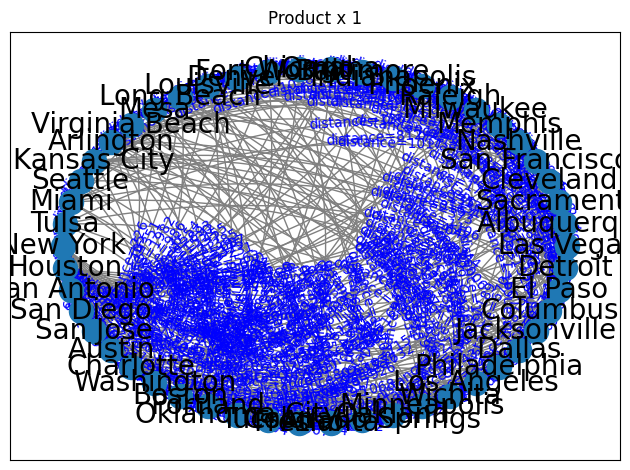

In [22]:
import itertools as it
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


def draw_labeled_multigraph(network_graph, attr_name, ax=None):
    """
    Length of connectionstyle must be at least that of a maximum number of edges
    between pair of nodes. This number is maximum one-sided connections
    for directed graph and maximum total connections for undirected graph.
    """
    # Works with arc3 and angle3 connectionstyles
    connectionstyle = [f"arc3,rad={r}" for r in it.accumulate([0.15] * 4)]
    # connectionstyle = [f"angle3,angleA={r}" for r in it.accumulate([30] * 4)]

    pos = nx.shell_layout(network_graph)
    nx.draw_networkx_nodes(network_graph, pos, ax=ax)
    nx.draw_networkx_labels(network_graph, pos, font_size=20, ax=ax)
    nx.draw_networkx_edges(
        network_graph, pos, edge_color="grey", connectionstyle=connectionstyle, ax=ax
    )

    labels = {
        tuple(edge): f"{attr_name}={attrs[attr_name]}"
        for *edge, attrs in network_graph.edges(keys=True, data=True)
    }
    nx.draw_networkx_edge_labels(
        network_graph,
        pos,
        labels,
        connectionstyle=connectionstyle,
        label_pos=0.3,
        font_color="blue",
        bbox={"alpha": 0},
        ax=ax,
    )

# nodes = "ABC"
prod = list(it.product(G.nodes, repeat=2))
pair_dict = {f"Product x {i}": prod * i for i in range(1, 3)}
# fig, axes = plt.subplots(1, 1)

# for (name, pairs), ax in zip(pair_dict.items(), np.ravel(axes)):
#     draw_labeled_multigraph(G, "available_bandwidth", ax)
#     ax.set_title(name)
# fig.tight_layout()
# plt.show()

distance_graph = nx.MultiGraph()
for i in G.edges:
    if(i[2] == 0):
        a_node = i[0]
        z_node = i[1]
        # print(a_node, z_node)
        # print(G[a_node][z_node][i[2]]['distance'])
        distance_graph.add_nodes_from([a_node,z_node])
        distance_graph.add_edges_from([(a_node,z_node,{'distance':G[a_node][z_node][i[2]]['distance']})])
        
fig, axes = plt.subplots(1, 1)
for (name, pairs), ax in zip(pair_dict.items(), np.ravel(axes)):
    draw_labeled_multigraph(distance_graph, "distance", ax)
    ax.set_title(name)
fig.tight_layout()
plt.show()

In [28]:
distance_graph.adj

MultiAdjacencyView({'New York': {'Houston': {0: {'distance': 1165}}, 'San Antonio': {0: {'distance': 218}}, 'San Diego': {0: {'distance': 666}}, 'San Jose': {0: {'distance': 1212}}, 'Austin': {0: {'distance': 1334}}, 'Charlotte': {0: {'distance': 732}}, 'Washington': {0: {'distance': 806}}, 'Boston': {0: {'distance': 1169}}, 'Portland': {0: {'distance': 770}}, 'Oklahoma City': {0: {'distance': 748}}, 'Tucson': {0: {'distance': 1209}}, 'Fresno': {0: {'distance': 1368}}, 'Atlanta': {0: {'distance': 223}}, 'Colorado Springs': {0: {'distance': 1220}}, 'Oakland': {0: {'distance': 1593}}, 'Minneapolis': {0: {'distance': 377}}, 'Wichita': {0: {'distance': 224}}}, 'Houston': {'New York': {0: {'distance': 1165}}, 'Los Angeles': {0: {'distance': 1759}}, 'Philadelphia': {0: {'distance': 1199}}, 'Dallas': {0: {'distance': 714}}, 'Austin': {0: {'distance': 1770}}, 'Jacksonville': {0: {'distance': 1118}}, 'Columbus': {0: {'distance': 656}}, 'Charlotte': {0: {'distance': 593}}, 'Washington': {0: {'di

In [29]:
nx.shortest_path(distance_graph,'New York','Nashville', weight = 'distance')

['New York', 'Atlanta', 'Louisville', 'Oklahoma City', 'Nashville']